In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import os
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
import functools
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
df_eval = pd.read_csv(os.path.join(os.path.abspath('../data'), 'model_evaluation.csv'))

In [3]:
df_eval.head()

,name,model,params,rmse_cv,std_cv,rmse_testset,mae_testset,custom_features,custom_target,all_scores_cv,pipe_file_name
0,RandomForest,"RandomForestRegressor(max_depth=19, min_sample...","[{'regressor__model__n_estimators': 1400, 'reg...",322.454,91.889,225.705413,78.156945,True,True,[263.54849944 472.7463774 283.12604915 377.84...,v1_pipe_RandomForest_322.454_20210728_124855.p...
1,XGB,"XGBRegressor(base_score=0.5, booster='gbtree',...","[{'regressor__model__n_estimators': 1000, 'reg...",324.991,88.407,226.596836,94.619457,True,True,[259.87817074 480.97906764 277.55397695 363.74...,v1_pipe_XGB_324.991_20210728_124855.pickle
2,LGBM,"LGBMRegressor(boosting_type='goss', colsample_...","[{'regressor__model__num_leaves': 1000, 'regre...",348.468,89.088,260.992615,131.221790,True,True,[284.15600368 501.48340321 308.43094224 392.49...,v1_pipe_LGBM_348.468_20210728_124855.pickle
3,Ridge,Ridge(alpha=0.6903100000000001),"[{'regressor__model__fit_intercept': True, 're...",5388.669,7224.577,2086.997941,746.461195,True,True,[ 1551.15882511 19834.51105925 1693.12576296 ...,v1_pipe_Ridge_5388.669_20210728_124855.pickle
4,NeuralNetwork,<tensorflow.python.keras.wrappers.scikit_learn...,"[{'regressor__model__optimizer': 'SGD', 'regre...",784.204,587.387,500.301091,285.152668,True,True,[ 447.21699185 1955.97805306 449.69563494 56...,v1_pipe_NeuralNetwork_784.204_20210728_124855....


Since we have serialized our models with the custom functions, we have to load them to our models work.

In [4]:
def create_model(optimizer='adam', dropout=0.2, activation='relu', kernel_initializer='normal'):
    model = Sequential()
    model.add(Dense(units = 15, activation = activation, input_dim = 15, kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(units = 11, activation = activation))
    model.add(Dropout(dropout))
    model.add(Dense(units = 1, activation = activation))

    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    return model

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor

class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        # print('FeatureCreation initialized')
        return None
    
    # For the fit method, we will pass the parameter x. This is our independent variables. 
    # This fit method will be called when we fit the pipeline.
    def fit(self, x, y=None):
        # print('Fit FeatureCreation called')
        return self
    
    # Here, we will perform all of our transformations. For creating features automatic, we could create parameters in the class and pass the column names to them.
    # But in this case, since it's for this dataset specific, we will perform transformations in the column names directly into the fit method.
    # The transform method is called when we fit and when we predict using the Pipeline. And that's make sense, since we need to create our feature when we will train and when we will predict.
    def transform(self, x, y=None):
        # print('Transform FeatureCreation called')
        # creating a copy to avoid changes to the original dataset
        x_ = x.copy()
        # print(f'Before Transformation: {x_.shape}')
        # and now, we create everyone of our features.
        # Area power of two
        x_['area2'] = x_['area'] ** 2
        # The ratio between area and rooms
        x_['area/room'] = x_['area'] / x_['rooms']
        # The ratio between area and bathroom
        x_['area/bathroom'] = x_['area'] / x_['bathroom']
        # the sum of rooms and bathrooms
        x_['rooms+bathroom'] = x_['rooms'] + x_['bathroom']
        # the product between rooms and bathrooms
        x_['rooms*bathroom'] = x_['rooms'] * x_['bathroom']
        # the ratio between rooms and bathrooms
        x_['rooms/bathroom'] = x_['rooms'] / x_['bathroom']
        # the product between hoa and property tax
        x_['hoa*property tax'] = x_['hoa (R$)'] * x_['property tax (R$)']
        # print(f'After Transformation: {x_.shape}')
        return x_

Load our data and split into train and test.

In [6]:
# df = pd.read_csv()
df = pd.read_csv(os.path.join(os.path.abspath('../data'), 'houses_to_rent_v2_fteng.csv'))
x = df.drop(columns=['rent amount (R$)'], axis=1)
y = df['rent amount (R$)']
# check if the random state it is equal to when it was trained, this is very important.
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=0)

Since we have saved our file name into the pipe_file_name column in the df_eval, let's iterate through every model and load it.

## Load the models

In [9]:
# for file in os.listdir(os.path.join(os.path.abspath(''), "models")):
rep = {"pipe": "model", "pickle": "h5"}
models_list = os.listdir(os.path.abspath('../models'))
for index, row in df_eval.iterrows():
    # check if the file_name is in our models directory
    if row['pipe_file_name'] in models_list:
        # now, load the model.
        with open(os.path.join(os.path.abspath('../models'), row['pipe_file_name']), 'rb') as fid:
            model_trained = pickle.load(fid)
        
        # for the keras model, we have to load the model separately and add into the pipeline or transformed target object.
        if row['name'] == 'NeuralNetwork':
            model_keras = load_model(os.path.join(os.path.abspath('../models'), functools.reduce(lambda a, kv: a.replace(*kv), rep.items(), row['pipe_file_name'])))
            # check if the target transformer it is active
            if row['custom_target']:
                # reconstruct the model inside a kerasregressor and add inside the transformed target object
                model_trained.regressor.set_params(model = KerasRegressor(build_fn=create_model, verbose=0))
                # add the keras model inside the pipeline object
                model_trained.regressor_.named_steps['model'].model = model_keras
            else:
                model_trained.named_steps['model'].model = model_keras
        df_eval.loc[index, 'model_trained'] = model_trained           

C:\Users\artur\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:993: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


## Model Evaluation

### RMSE

In [10]:
df_eval.sort_values(by='rmse_cv').head()

,name,model,params,rmse_cv,std_cv,rmse_testset,mae_testset,custom_features,custom_target,all_scores_cv,pipe_file_name,model_trained
10,RandomForest,"RandomForestRegressor(max_depth=48, n_estimato...","[{'regressor__model__n_estimators': 1400, 'reg...",319.495,96.855,233.987982,71.901280,False,True,[263.08498584 486.75696648 276.66577584 361.63...,v1_pipe_RandomForest_319.495_20210728_132655.p...,"TransformedTargetRegressor(func=<ufunc 'log'>,..."
11,XGB,"XGBRegressor(base_score=0.5, booster='gbtree',...","[{'regressor__model__n_estimators': 1000, 'reg...",321.228,85.971,240.502832,107.658353,False,True,[265.37773095 466.29289527 279.22007038 368.02...,v1_pipe_XGB_321.228_20210728_132655.pickle,"TransformedTargetRegressor(func=<ufunc 'log'>,..."
0,RandomForest,"RandomForestRegressor(max_depth=19, min_sample...","[{'regressor__model__n_estimators': 1400, 'reg...",322.454,91.889,225.705413,78.156945,True,True,[263.54849944 472.7463774 283.12604915 377.84...,v1_pipe_RandomForest_322.454_20210728_124855.p...,"TransformedTargetRegressor(func=<ufunc 'log'>,..."
15,RandomForest,"RandomForestRegressor(max_depth=14, min_sample...","[{'model__n_estimators': 800, 'model__min_samp...",323.176,97.598,233.372226,75.709450,False,False,[268.48237502 494.11961816 277.8636969 361.34...,v1_pipe_RandomForest_323.176_20210728_134028.p...,"(ColumnTransformer(transformers=[('numeric',\n..."
5,RandomForest,"RandomForestRegressor(max_depth=14, min_sample...","[{'model__n_estimators': 1400, 'model__min_sam...",323.492,93.867,226.917325,77.277742,True,False,[265.91888239 478.82988079 279.1950981 378.05...,v1_pipe_RandomForest_323.492_20210728_130720.p...,"(FeatureCreation(), ColumnTransformer(transfor..."


We can see that RandomForest appears to be our best model regarding to RMSE. This model also appears in 4 of our 5 best models, followed by XGB with 1 model.

## Distribution

In [11]:
import plotly.figure_factory as ff

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(
    [y_test, df_eval['model_trained'].iloc[0].predict(x_test)], 
    ['Real', 'Predicted'],
    # nbins=50,
    bin_size=150,
    # show_hist=False
    # colors=['#636EFA', '#EF553B']
)
    # show_hist=False)

# Add title
fig.update_layout(title_text='Predicted and Real Value')
fig.show()

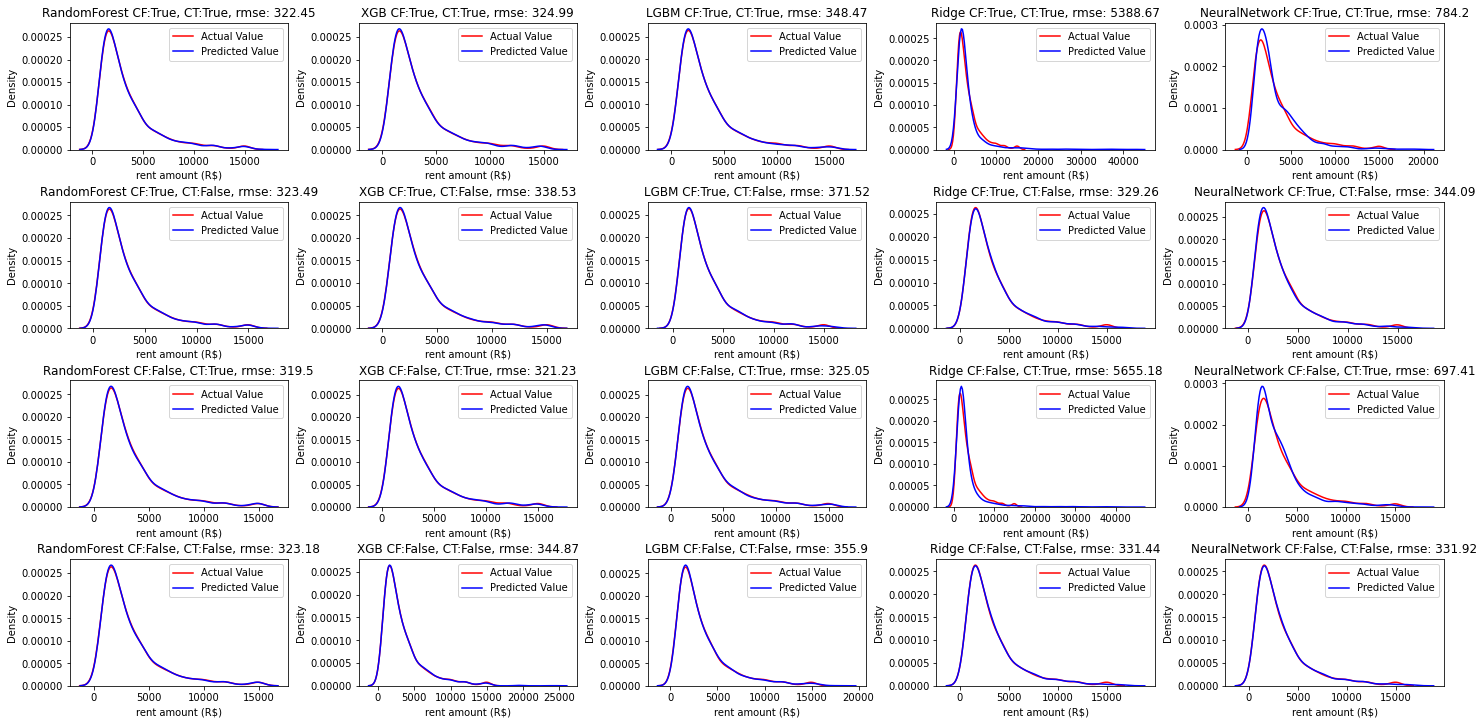

In [12]:
# Let's see the distribution of our predicted values in comparison with the actual values.
j = 1
plt.figure(figsize=(20,10))
for name, custom_feature, custom_target, model_trained, score in df_eval[['name', 'custom_features', 'custom_target', 'model_trained', 'rmse_cv']].values:
    prediction = model_trained.predict(x_test)

    plt.subplot(4, 5, j)
    ax1 = sns.kdeplot(y_test,color ="r",label ="Actual Value")
    sns.kdeplot(prediction ,color ="b",label = "Predicted Value",ax =ax1).set_title(name + ' ' + 'CF:' + str(custom_feature) + ', ' + 'CT:' + str(custom_target) + f', rmse: {round(score, 2)}')
    j+=1
    plt.legend()
plt.tight_layout(pad = 0.5)

We can see that the model is very accurate, and that cause the curves to overlap. 

There are some models that don't have a good RMSE, but the curves are still very similar to each other, this can be caused by a few values ​​that have a very high error.

### Boxplot

Now, let's create a function to plot a boxplot for every model in our combinations. 

In [13]:
# We will use plotly for interactivity
import plotly.graph_objects as go
class PlotBoxR(object):
    def __Trace(self,nameOfFeature,value): 
        trace = go.Box(
            y=value,
            name = nameOfFeature,
        )
        return trace

    def PlotResult(self,names,results,combination):
        data = []
        for i in range(len(names)):
            data.append(self.__Trace(names.iloc[i],results.iloc[i]))
        figure = go.Figure(data=data)
        figure.update_layout(title=str(combination))
        return figure

In [14]:
# we have to transform our score column to bring it back to a python list
df_eval['all_scores_cv'] = df_eval['all_scores_cv'].apply(lambda x: [float(i) for i in x.strip('[]').split()])

In [15]:
combinations = ({'custom_feature': True, 'custom_target': True}, {'custom_feature': True, 'custom_target': False}, {'custom_feature': False, 'custom_target': True}, {'custom_feature': False, 'custom_target': False})
for combination in combinations:
    plot_df = df_eval.loc[(df_eval['custom_features'] == combination['custom_feature']) & (df_eval['custom_target'] == combination['custom_target'])]
    PlotBoxR().PlotResult(plot_df['name'],plot_df['all_scores_cv'], combination).show()

In [16]:
# # now let's follow the same loop and visualize the plot's for each regressor
# j = 1
# plt.figure(figsize=(20,10))
# for name, custom_feature, custom_target, model_trained in df_eval[['name', 'custom_features', 'custom_target', 'model_trained']].values:
#     prediction = model_trained.predict(x_test)
        
#     plt.subplot(4, 5, j)
#     sns.residplot(x=prediction, y=y_test, lowess=True, color="g").set_title(name + ' ' + 'CF:' + str(custom_feature) + ', ' + 'CT:' + str(custom_target))
#     j+=1
#     # plt.legend()
# plt.tight_layout(pad = 0.5)

### Residuals

In [17]:
import plotly.express as px
from sklearn.metrics import r2_score

# Now, let's check out the residuals of each model.
# Select the model as you want, here i'm selecting the most accurate model
model = df_eval.sort_values(by='rmse_cv')['model_trained'].iloc[4]
# predict the values of the entire data
prediction = model.predict(x)
# calculate the residual
resid = prediction - y

# create a copy to not alter the original data
df_plot = df.copy()
# create a column to identify the data regarding to train or test
df_plot['split'] = 'train'
df_plot.loc[x_test.index, 'split'] = 'test'
df_plot['prediction'] = prediction
df_plot['resid'] = resid

# plot the residual plot with the histograms
fig = px.scatter(
    df_plot, x='prediction', y='resid',
    marginal_x='histogram', marginal_y='histogram',
    color='split', trendline='ols', opacity=.5
)

# add an annotation with the train R2
fig.add_annotation(
            xref="paper",
            yref="paper",
            x=0.005,
            y=0.70,
            text=f"Train R²: {round(r2_score(df_plot.loc[df_plot['split'] == 'train']['rent amount (R$)'], df_plot.loc[df_plot['split'] == 'train']['prediction']), 3)}",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="red",
            opacity=0.8,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#ffffff"
            )
            )

# add an annotation with the test R2
fig.add_annotation(
            xref="paper",
            yref="paper",
            x=0.080,
            y=0.70,
            text=f"Test R²: {round(r2_score(df_plot.loc[df_plot['split'] == 'test']['rent amount (R$)'], df_plot.loc[df_plot['split'] == 'test']['prediction']), 3)}",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="blue",
            opacity=0.8,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#ffffff"
            )
            )

# add an annotation with the train RMSE
fig.add_annotation(
            xref="paper",
            yref="paper",
            x=0.005,
            y=0.005,
            text=f"Train RMSE: {round(mean_squared_error(df_plot.loc[df_plot['split'] == 'train']['rent amount (R$)'], df_plot.loc[df_plot['split'] == 'train']['prediction'], squared=False), 2)}",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="red",
            opacity=0.8,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#ffffff"
            )
            )

# add an annotation with the test RMSE
fig.add_annotation(
            xref="paper",
            yref="paper",
            x=0.1,
            y=0.005,
            text=f"Test RMSE: {round(mean_squared_error(df_plot.loc[df_plot['split'] == 'test']['rent amount (R$)'], df_plot.loc[df_plot['split'] == 'test']['prediction'], squared=False), 2)}",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="blue",
            opacity=0.8,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#ffffff"
            )
            )

fig.show()

We can see that the distribution of the residuals doesn't follow a pattern and it is similar to a normal distribution, which is good.

The train RMSE it is similar to the test, which indicates that our model isn't overfitted and can perform well on new data.